In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.inceptionv3 import inceptionv3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'training_set'
valid_path = 'test_set'

In [4]:
# useful for getting number of output classes
folders = glob('training_set/*')

In [5]:
folders

['training_set\\cats', 'training_set\\dogs']

In [6]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [8]:
x = Flatten()(inception.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
train_generator = train_datagen.flow_from_directory('training_set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 ) # set as training data

Found 8005 images belonging to 2 classes.


In [22]:
valid_generator = test_datagen.flow_from_directory('test_set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False,
                                            ) 

Found 2023 images belonging to 2 classes.


In [16]:
earlystopper=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [17]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=20,
  steps_per_epoch=len(train_generator),
  validation_steps=len(valid_generator),
  callbacks = [earlystopper]
)

C:\Users\DELL\anaconda3\envs\marzharenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
251/251 [==============================] - 138s 500ms/step - loss: 0.4647 - accuracy: 0.9671 - val_loss: 0.1943 - val_accuracy: 0.9822
Epoch 2/20
251/251 [==============================] - 79s 315ms/step - loss: 0.3112 - accuracy: 0.9804 - val_loss: 0.2914 - val_accuracy: 0.9867
Epoch 3/20
251/251 [==============================] - 82s 327ms/step - loss: 0.5451 - accuracy: 0.9805 - val_loss: 0.4121 - val_accuracy: 0.9842
Epoch 4/20
251/251 [==============================] - 84s 333ms/step - loss: 0.2784 - accuracy: 0.9883 - val_loss: 0.4265 - val_accuracy: 0.9847
Epoch 5/20
251/251 [==============================] - 85s 338ms/step - loss: 0.2341 - accuracy: 0.9903 - val_loss: 0.4000 - val_accuracy: 0.9886
Epoch 6/20
251/251 [==============================] - 85s 338ms/step - loss: 0.2643 - accuracy: 0.9908 - val_loss: 0.4738 - val_accuracy: 0.9837
Epoch 00006: early stopping


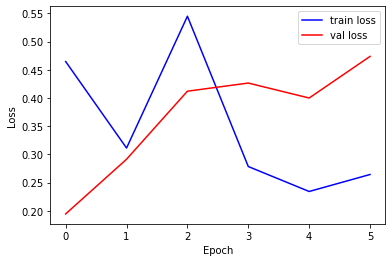

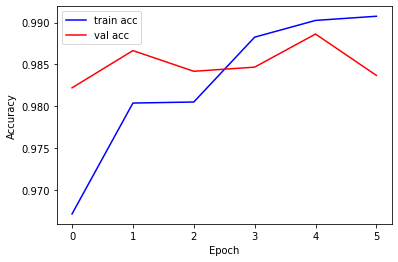

In [18]:
# plot the loss
plt.plot(r.history['loss'],'b', label='train loss')
plt.plot(r.history['val_loss'],'r', label='val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'],'b', label='train acc')
plt.plot(r.history['val_accuracy'],'r', label='val acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
test_loss, test_acc = model.evaluate(valid_generator, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

64/64 - 4s - loss: 0.4738 - accuracy: 0.9837
Test accuracy: 0.9836875796318054
Test loss: 0.4738036096096039


In [20]:
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc, roc_auc_score

In [23]:
valid_generator.reset()
# get the ground truth of your data. 
y_true = valid_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(valid_generator, verbose=2)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=1)

# get the confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

64/64 - 4s
[[1006    5]
 [  28  984]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1011
           1       0.99      0.97      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023



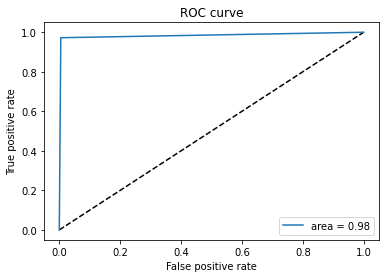

ROC AUC SCORE: 0.9836932086964342


In [24]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print('ROC AUC SCORE:', auc_keras)

In [25]:
from tensorflow.keras.models import load_model

model.save('logs/catdog_inceptionv3.h5')

In [26]:
model = tf.keras.models.load_model('logs/catdog_inceptionv3.h5')

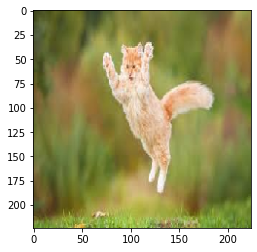

In [27]:
img=image.load_img('cats1.jfif',target_size=(224,224))
plt.imshow(img)

In [28]:
x=image.img_to_array(img)
x=x/255

In [29]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [30]:
result = model.predict(img_data)
a=np.argmax(model.predict(img_data), axis=1)

In [31]:
result

array([[1.0000000e+00, 7.2112877e-10]], dtype=float32)

0 : 100.00000 %
1 : 0.00000 %
Predicted : Cats


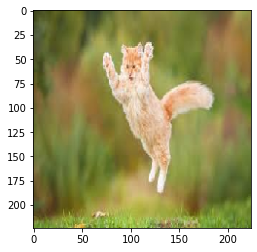

In [33]:
plt.imshow(img)
b = -1
for i in [1.0000000e+00, 7.2112877e-10] :
    b = b + 1
    print(b, ':', '%0.5f'%(i*100),'%')
    
if(a==0):
    print("Predicted : Cats")

else:
    print("Predicted : Dogs")